## CMS Interpolation
---

In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from script import utils, cms, hep
from script.utils import free_mem

from script.hep.data import BalancedSequence, UniformSequence
from script.models.layers import Divide, StandardScaler, Clip
from script.datasets import Benchmark

cms.plot.set_style()

In [7]:
# for debugging, comment if not needed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
utils.set_random_seed(42)

Random seed 42 set.


In [9]:
# statistics
clip = hep.retrieve_clip(ranges=Benchmark.CLIP_RANGES, columns=Benchmark.FEATURES)
mean = hep.retrieve_stat(stats=Benchmark.STATS, which='mean', columns=Benchmark.FEATURES)
std = hep.retrieve_stat(stats=Benchmark.STATS, which='std', columns=Benchmark.FEATURES)

In [10]:
# preprocessing layers
preproc = dict(x=[Clip(min_value=clip[:, 0], max_value=clip[:, 1]),
                  StandardScaler(mean, std)],
               m=[Divide(value=1000.0)])

---

In [11]:
# load training data
data = Benchmark()
data.load(signal='data/benchmark/signal_bassociated_train.csv',
          bkg='data/benchmark/background_train.csv')

[signal] loading...
[background] loading...
dataset loaded.


In [12]:
# load test data
test = Benchmark()
test.load(signal='data/benchmark/signal_bassociated_test.csv',
          bkg='data/benchmark/background_test.csv')

[signal] loading...
[background] loading...
dataset loaded.


In [13]:
data.unique_signal_mass

array([ 110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,  190.,
        200.,  225.,  250.,  275.,  300.,  350.,  400.,  450.,  500.,
        600.,  700.,  800.,  900., 1000.], dtype=float32)

In [14]:
# select training masses (the missing mA are the one we're going to interpolate)
idx = np.arange(start=0, stop=len(data.unique_signal_mass), step=2)

train_mass = data.unique_signal_mass[idx]
train_mass

array([ 110.,  130.,  150.,  170.,  190.,  225.,  275.,  350.,  450.,
        600.,  800., 1000.], dtype=float32)

In [15]:
# create trainining set
interp = Benchmark()
interp.load(signal=pd.concat([data.signal[data.signal['mA'] == m] for m in train_mass]),
            bkg=data.background)

[signal] loading...
[background] loading...
dataset loaded.


In [16]:
free_mem()

22

In [17]:
def compare(paths_and_args: dict, dataset, bins=50, **kwargs):
    models = {}
    
    for path, args in paths_and_args.items():
        name = args.pop('name')
        cls_fn = args.pop('cls', utils.get_compiled_pnn)
        
        model = cls_fn(dataset, **args)
        utils.load_from_checkpoint(model, path=path)
        
        models[name] = model
        
    # ROC & PR
    ax1, ax2 = utils.get_plot_axes(rows=1, cols=2)

    cms.plot.auc_vs_mass(dataset, models, ax=ax1, which='ROC', **kwargs)
    cms.plot.auc_vs_mass(dataset, models, ax=ax2, which='PR', **kwargs)

    plt.tight_layout()
    plt.show()

    # significance
    cms.plot.significance_ratio_vs_mass(dataset, models, bins=bins, title='weighted')

--- 
### Uniform (fixed)

**Naive:** fixed, without any balance, regularization and preprocessing. Also validation is made on original mass, without weighting the background.
* *Overfits the training data*, even if validation AUC keeps increasing towards 1.
* This results in *mass overfitting*, which prevents correct interpolation of the missing signal mA.

In [13]:
train, valid = cms.data.train_valid_split(interp)

train = cms.data.SimpleEvalSequence(signal=train[0], background=train[1], batch_size=128,
                                    features=data.columns['feature'], sample_mass=False,
                                    weight_column=None)

valid = cms.data.SimpleEvalSequence(signal=valid[0], background=valid[1], batch_size=1024,
                                    features=data.columns['feature'],
                                    weight_column=None, sample_mass=False)

In [18]:
model, checkpoint = utils.get_compiled_pnn(interp,
                                           save='benchmark/interp/pnn-uniform-fixed-naive')

In [20]:
model.fit(x=train, epochs=100, validation_data=valid, verbose=2, callbacks=[checkpoint])

4728/4728 - 21s - loss: 0.1619 - binary_accuracy: 0.9424 - auc: 0.9828 - precision: 0.8831 - recall: 0.8882 - ams: 0.8867 - class-loss: 0.1437 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 8.9559 - weight-norm: 64.4729 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1419 - val_binary_accuracy: 0.9465 - val_auc: 0.9839 - val_precision: 0.8747 - val_recall: 0.9186 - val_ams: 0.8964
Epoch 2/50
4728/4728 - 18s - loss: 0.1569 - binary_accuracy: 0.9429 - auc: 0.9828 - precision: 0.8848 - recall: 0.8886 - ams: 0.8876 - class-loss: 0.1442 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 8.9889 - weight-norm: 64.8879 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1383 - val_binary_accuracy: 0.9449 - val_auc: 0.9845 - val_precision: 0.8676 - val_recall: 0.9211 - val_ams: 0.8952
Epoch 3/50
4728/4728 - 17s - loss: 0.1230 - binary_accuracy: 0.9434 - auc: 0.9830 - precision: 0.8841 - recall: 0.8915 - ams: 0.8886 - class-loss: 0.1422 - fool-loss: 0.00

In [21]:
utils.load_from_checkpoint(model, path='benchmark/interp/pnn-uniform-fixed-naive')

Loaded from "weights\benchmark/interp/pnn-uniform-fixed-naive\weights-47-0.995"


Baseline: fixed, without any *balance* and *preprocessing*.

In [ ]:
train, valid = cms.data.train_valid_split(interp)

train = cms.data.SimpleEvalSequence(signal=train[0], background=train[1], batch_size=1024,
                                    features=data.columns['feature'], sample_mass=False,
                                    weight_column=None)

valid = cms.data.SimpleEvalSequence(signal=valid[0], background=valid[1], batch_size=1024,
                                    features=data.columns['feature'])

In [13]:
model, checkpoint = utils.get_compiled_pnn(interp,
                                           save='benchmark/interp/pnn-uniform-fixed', 
                                           lr=3e-4, dropout=0.25,
                                           kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                           bias_regularizer=tf.keras.regularizers.l2(1e-5))

In [14]:
model.fit(x=train, epochs=50, validation_data=valid, verbose=2, callbacks=[checkpoint])

Epoch 1/50
591/591 - 13s - loss: 0.5278 - binary_accuracy: 0.7193 - auc: 0.6920 - precision: 0.4109 - recall: 0.2705 - ams: 0.5277 - class-loss: 0.9688 - fool-loss: 0.0000e+00 - lr: 3.0000e-04 - grad-norm: 3.7643 - weight-norm: 19.2582 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0369 - val_loss: 0.2398 - val_binary_accuracy: 0.8098 - val_auc: 0.9008 - val_precision: 0.7946 - val_recall: 0.3279 - val_ams: 0.7137
Epoch 2/50
591/591 - 12s - loss: 0.4383 - binary_accuracy: 0.8009 - auc: 0.8453 - precision: 0.6383 - recall: 0.4793 - ams: 0.6434 - class-loss: 0.4502 - fool-loss: 0.0000e+00 - lr: 3.0000e-04 - grad-norm: 0.9134 - weight-norm: 18.6464 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0346 - val_loss: 0.2217 - val_binary_accuracy: 0.8535 - val_auc: 0.9095 - val_precision: 0.7500 - val_recall: 0.6252 - val_ams: 0.7171
Epoch 3/50
591/591 - 12s - loss: 0.3812 - binary_accuracy: 0.8365 - auc: 0.8823 - precision: 0.6990 - recall: 0.6133 - ams: 0.6894 - class-loss: 0.4033 - fool-loss:

In [15]:
utils.load_from_checkpoint(model, path='benchmark/interp/pnn-uniform-fixed')

Loaded from "weights\benchmark/interp/pnn-uniform-fixed\weights-34-0.976"


Loaded from "weights\benchmark/interp/uniform-fixed/pnn\weights-34-0.976"
Loaded from "weights\benchmark/interp/uniform-fixed/pnn-naive\weights-97-0.995"
Loaded from "weights\benchmark/uniform-fixed/pnn\weights-21-0.973"


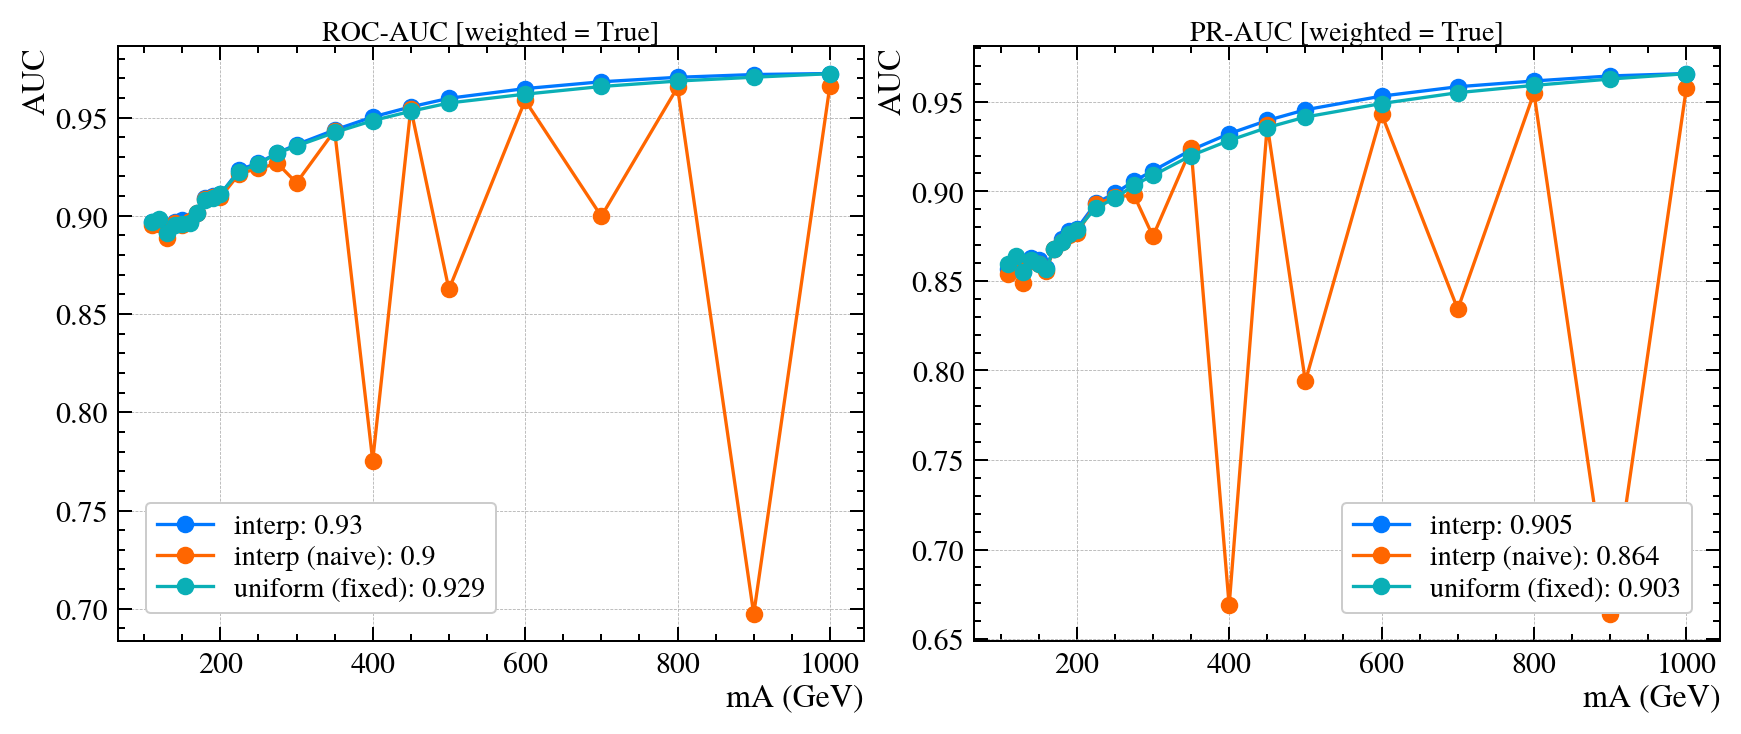

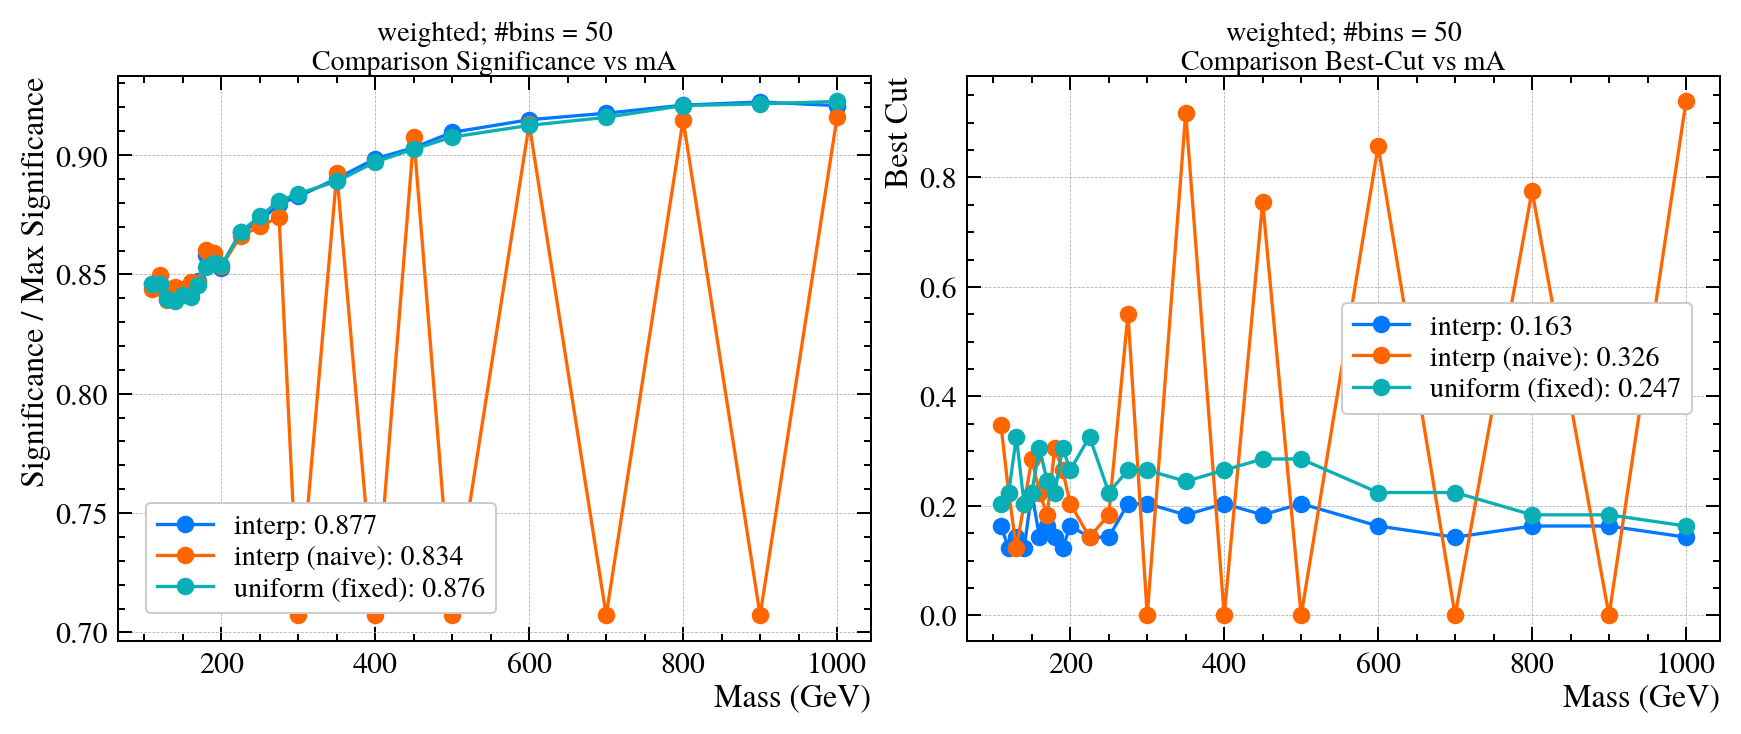

In [35]:
args = dict(dropout=0.25)
base_path ='uniform-fixed/pnn'

compare({f'benchmark/interp/{base_path}': dict(**args, name='interp'),
         f'benchmark/interp/{base_path}-naive': dict(name='interp (naive)'),
         f'benchmark/{base_path}': dict(**args, name='uniform (fixed)')}, test)

Loaded from "weights\benchmark/interp/uniform-fixed/pnn\weights-34-0.976"
Loaded from "weights\benchmark/uniform-fixed/pnn\weights-21-0.973"


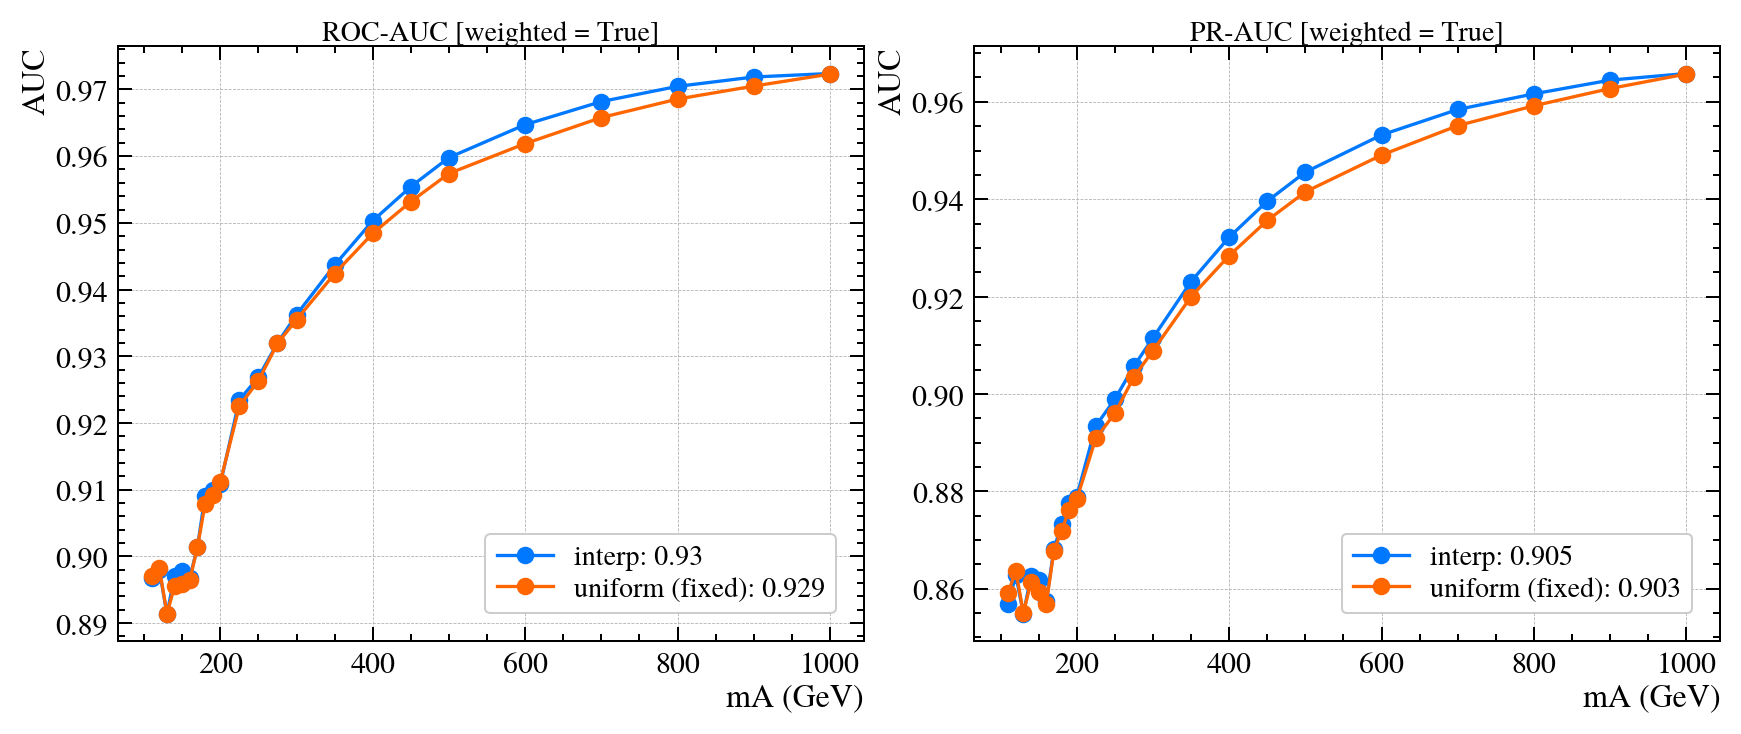

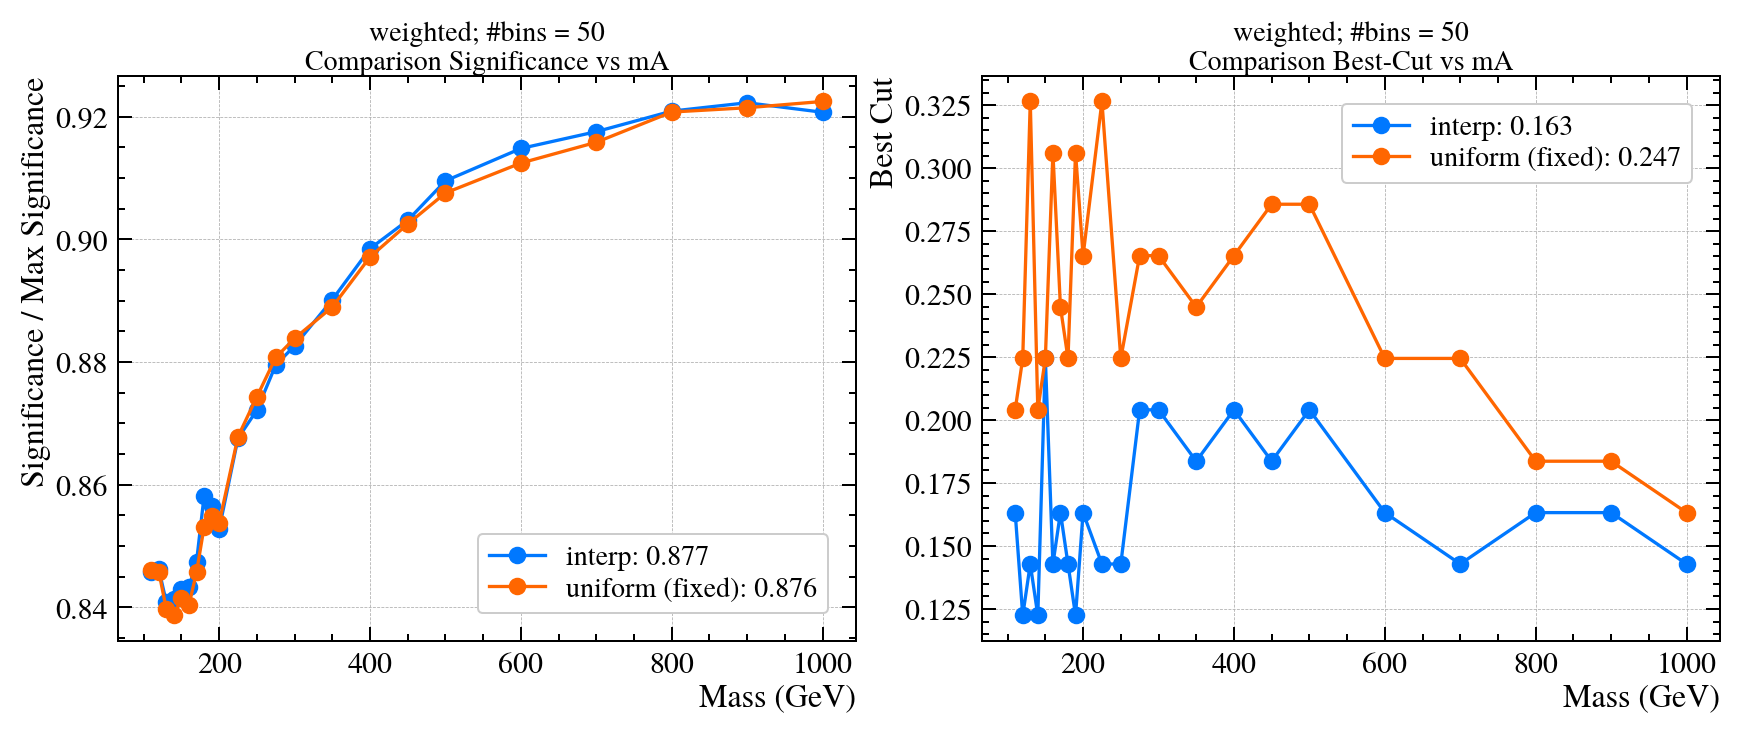

In [18]:
args = dict(dropout=0.25)
base = 'uniform-fixed/pnn'

compare({f'benchmark/interp/{base}': dict(**args, name='interp'),
         f'benchmark/{base}': dict(**args, name='uniform (fixed)')}, test)

Preprocessing + full-balance:

In [19]:
train, valid = cms.data.BalancedUniformSequence.get_data(interp)

In [20]:
model, checkpoint = utils.get_compiled_pnn(interp, dropout=0.25, preprocess=preproc, lr=3e-4,
                                           save='benchmark/interp/uniform-fixed/pnn-full_balance-preproc', 
                                           kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                                           bias_regularizer=tf.keras.regularizers.l2(1e-6))

In [21]:
model.fit(x=train, epochs=50, validation_data=valid, verbose=2, callbacks=[checkpoint])

Epoch 1/50
800/800 - 15s - loss: 0.2747 - binary_accuracy: 0.8625 - auc: 0.9125 - precision: 0.8665 - recall: 0.9384 - ams: 0.9025 - class-loss: 0.3375 - fool-loss: 0.0000e+00 - lr: 3.0000e-04 - grad-norm: 0.2420 - weight-norm: 20.6270 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0042 - val_loss: 0.0523 - val_binary_accuracy: 0.8185 - val_auc: 0.9365 - val_precision: 0.5856 - val_recall: 0.9488 - val_ams: 0.7707
Epoch 2/50
800/800 - 12s - loss: 0.2420 - binary_accuracy: 0.9005 - auc: 0.9443 - precision: 0.8981 - recall: 0.9595 - ams: 0.9287 - class-loss: 0.2602 - fool-loss: 0.0000e+00 - lr: 3.0000e-04 - grad-norm: 0.3022 - weight-norm: 20.7912 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0043 - val_loss: 0.0511 - val_binary_accuracy: 0.8427 - val_auc: 0.9451 - val_precision: 0.6230 - val_recall: 0.9469 - val_ams: 0.7891
Epoch 3/50
800/800 - 12s - loss: 0.2505 - binary_accuracy: 0.9072 - auc: 0.9495 - precision: 0.9056 - recall: 0.9610 - ams: 0.9332 - class-loss: 0.2459 - fool-loss:

In [22]:
utils.load_from_checkpoint(model, 
                           path='benchmark/interp/uniform-fixed/pnn-full_balance-preproc')

Loaded from "weights\benchmark/interp/uniform-fixed/pnn-full_balance-preproc\weights-46-0.963"


Evaluation (on all data):

Loaded from "weights\benchmark/interp/uniform-fixed/pnn-full_balance-preproc\weights-46-0.963"
Loaded from "weights\benchmark/uniform-fixed/pnn-full_balance-preproc\weights-44-0.962"


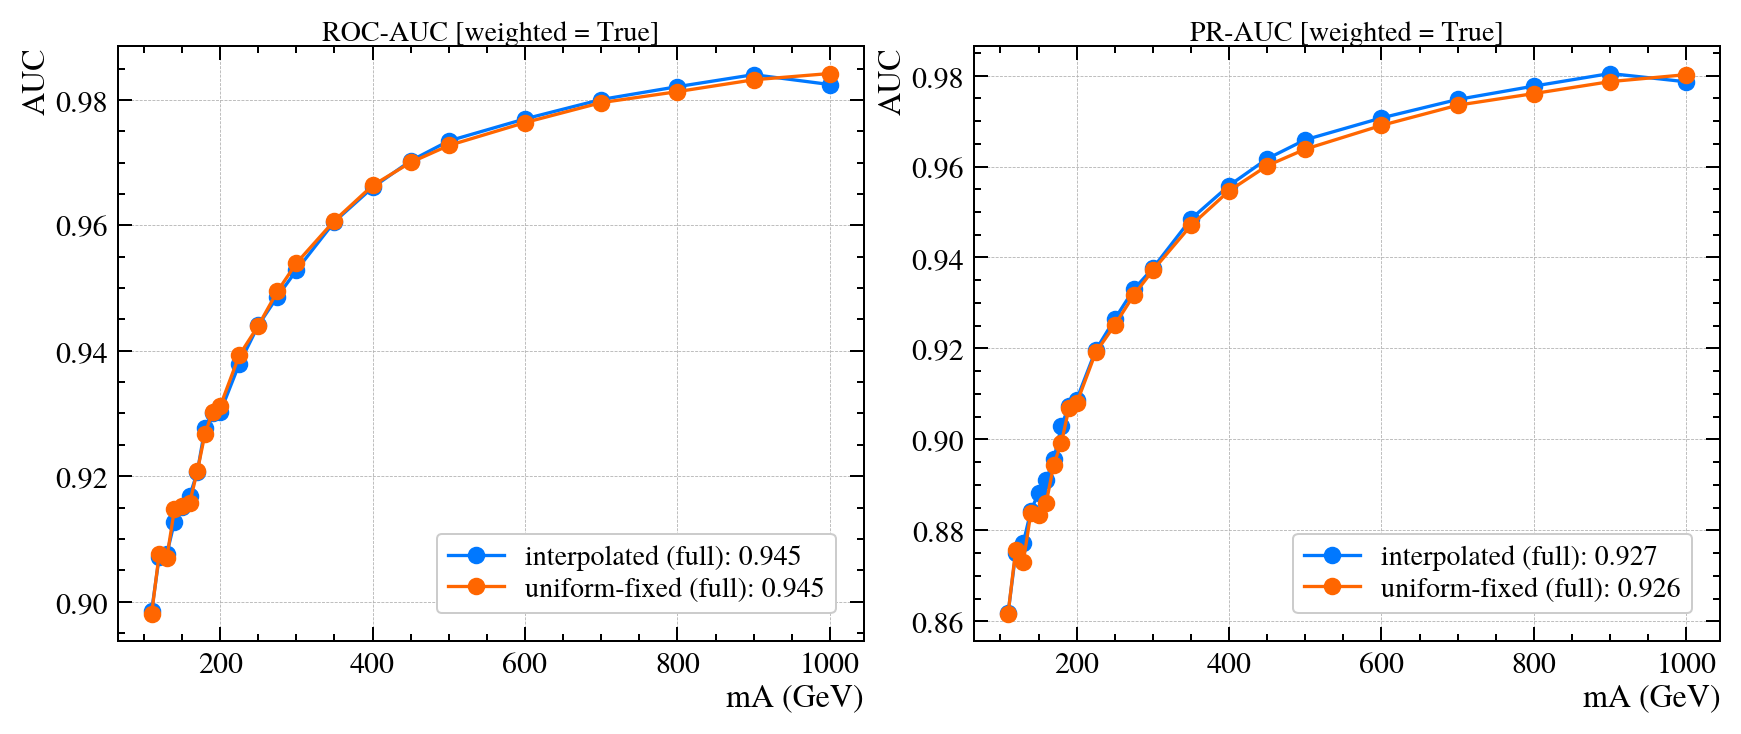

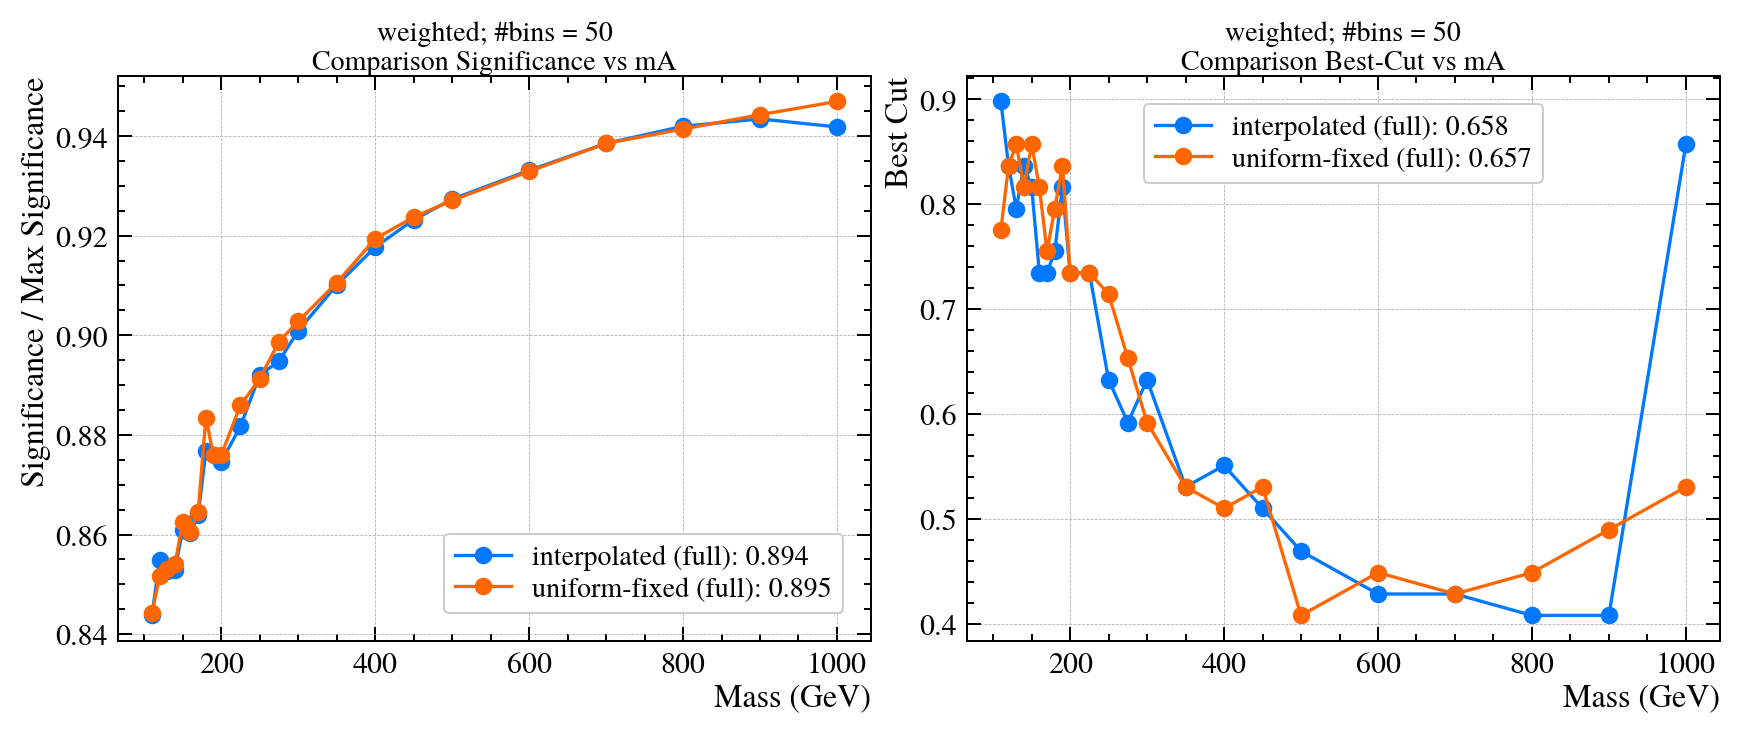

In [36]:
args = dict(dropout=0.25, preprocess=preproc)
base ='uniform-fixed/pnn-full_balance-preproc'

compare({f'benchmark/interp/{base}': dict(**args, name='interpolated (full)'),
         f'benchmark/{base}': dict(**args, name='uniform-fixed (full)')},
        test)

---
## Same (sampled)

Naive:
* Overfits just in few epochs.

In [ ]:
train, valid = cms.data.OneVsAllSequence.get_data(data)

In [25]:
model, checkpoint = utils.get_compiled_pnn(interp, 
                                           save='benchmark/interp/same-sampled/pnn-naive')

In [26]:
model.fit(x=train, epochs=100, validation_data=valid, verbose=2, callbacks=[checkpoint])

Epoch 1/100
732/732 - 12s - loss: 0.2517 - binary_accuracy: 0.8647 - auc: 0.9351 - precision: 0.8186 - recall: 0.8455 - ams: 0.8353 - class-loss: 0.3256 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 10.7837 - weight-norm: 20.9119 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0945 - val_binary_accuracy: 0.8857 - val_auc: 0.9576 - val_precision: 0.8189 - val_recall: 0.9132 - val_ams: 0.8662
Epoch 2/100
732/732 - 8s - loss: 0.2491 - binary_accuracy: 0.8893 - auc: 0.9553 - precision: 0.8516 - recall: 0.8724 - ams: 0.8630 - class-loss: 0.2645 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 9.0440 - weight-norm: 21.9324 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1024 - val_binary_accuracy: 0.8997 - val_auc: 0.9634 - val_precision: 0.8537 - val_recall: 0.9010 - val_ams: 0.8775
Epoch 3/100
732/732 - 9s - loss: 0.2365 - binary_accuracy: 0.8969 - auc: 0.9607 - precision: 0.8625 - recall: 0.8799 - ams: 0.8726 - class-loss: 0.2481 - fool-los

In [27]:
utils.load_from_checkpoint(model, path='benchmark/interp/same-sampled/pnn-naive')

Loaded from "weights\benchmark/interp/same-sampled/pnn-naive\weights-97-0.984"


Evaluation (on all data):

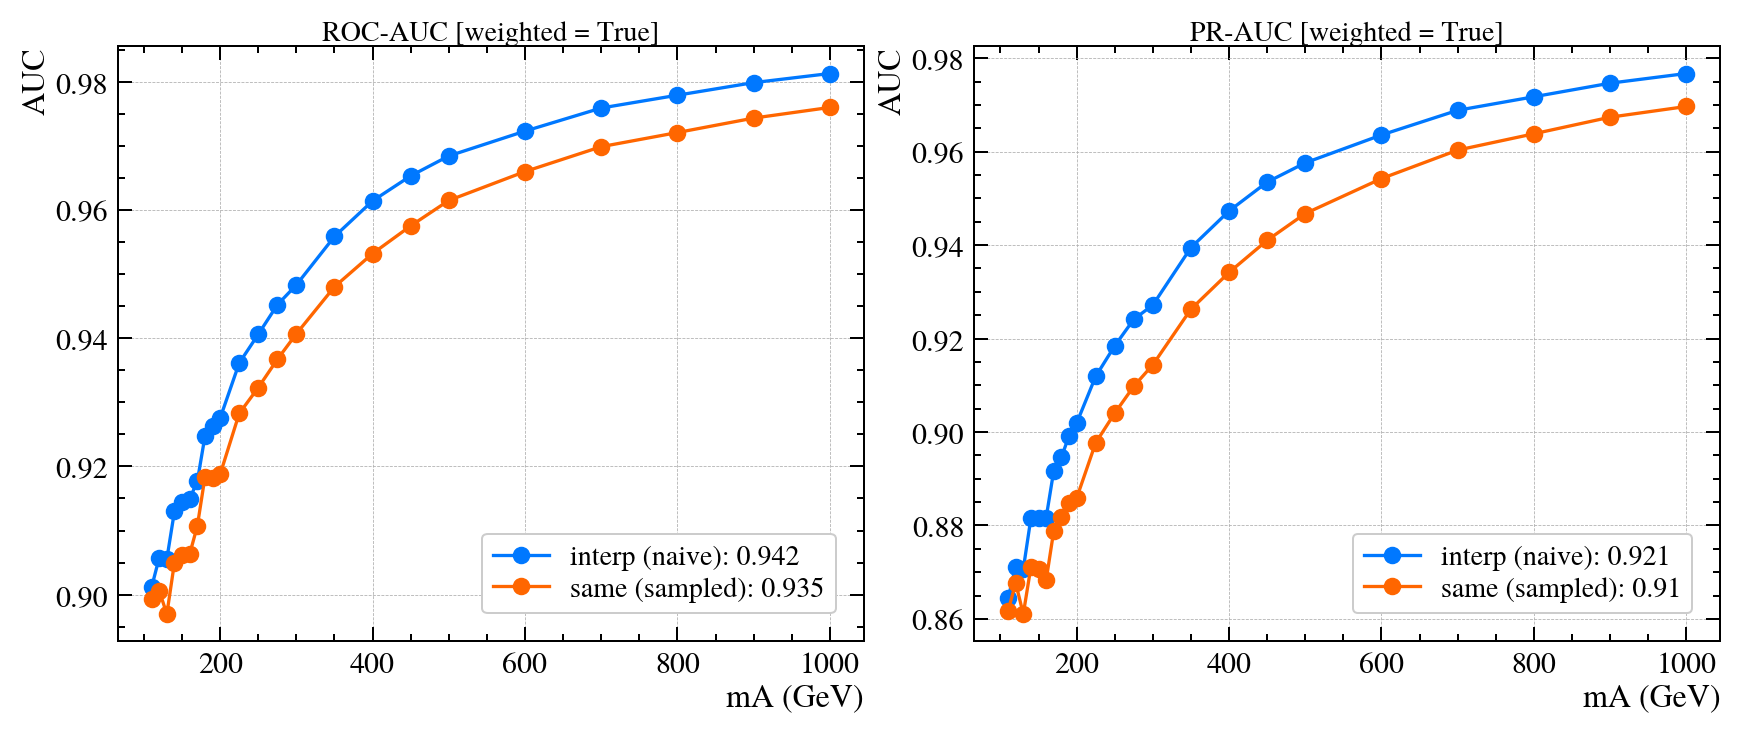

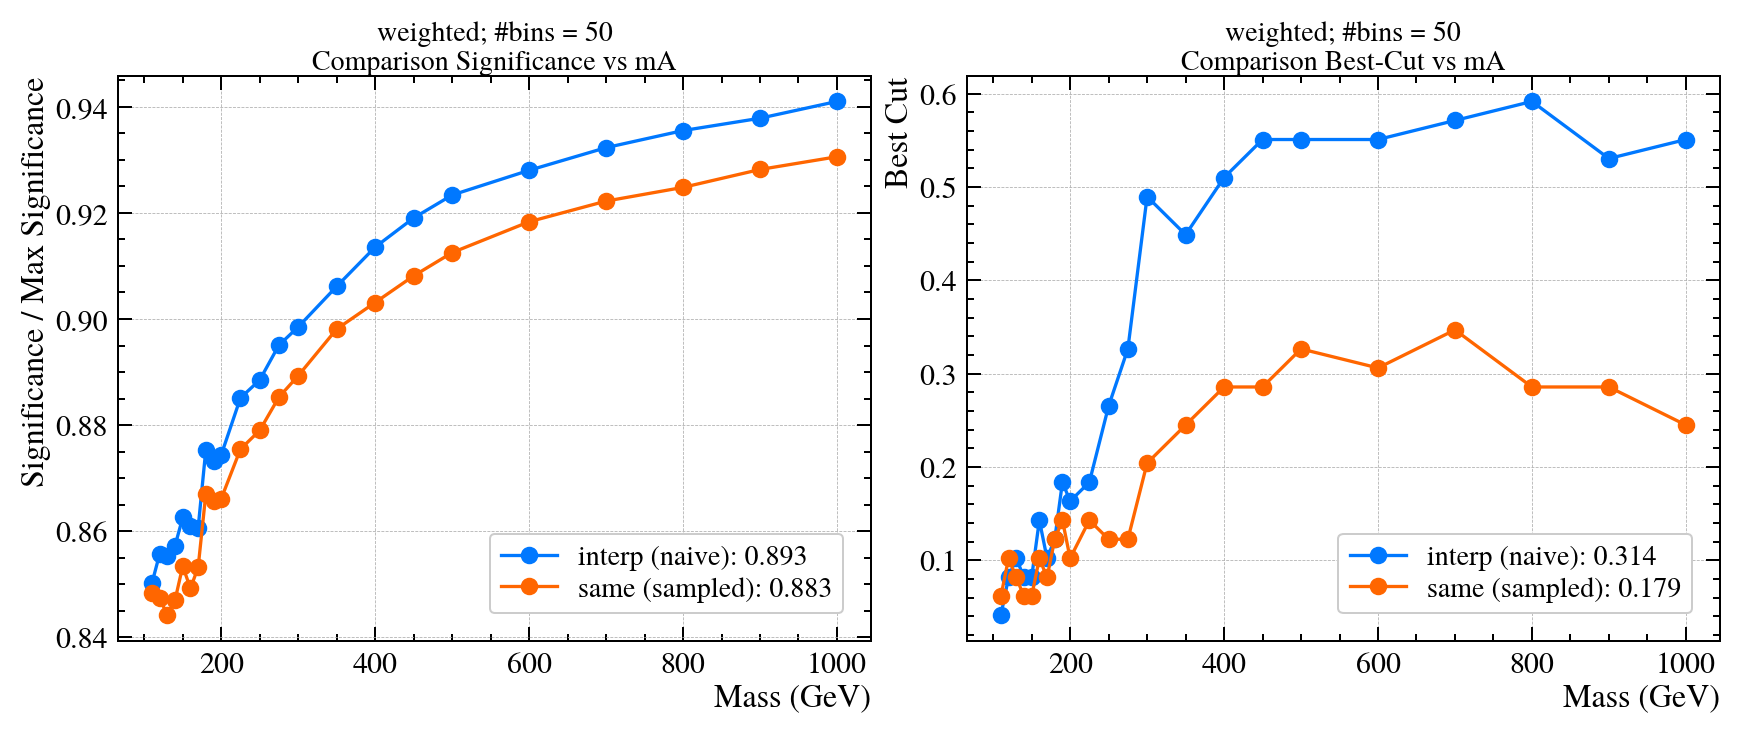

In [34]:
args = dict(dropout=0.25)
base ='same-sampled/pnn'

compare({f'benchmark/interp/{base}-naive': dict(name='interp (naive)'),
         f'benchmark/{base}': dict(**args, name='same (sampled)')},
        test)

* When the mA are *overhelming*, dropping some mA can have a **regularizing effect** that boosts generalization on the original data with all mA.

Full + preprocessing:

In [29]:
train, valid = cms.data.FullBalancedSequence.get_data(interp, sample_mass=True)

C:\Users\Luca\pNN4Higgs\script\cms\data.py:435: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.binned_mass = np.array(buckets)


In [30]:
model, checkpoint = utils.get_compiled_pnn(interp, dropout=0.25, preprocess=preproc, lr=3e-4,
                                           save='benchmark/interp/same-sampled/pnn-full_balance-preproc',
                                           kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                                           bias_regularizer=tf.keras.regularizers.l2(1e-6))

In [31]:
model.fit(x=train, epochs=50, validation_data=valid, verbose=2, callbacks=[checkpoint])

Epoch 1/50
590/590 - 14s - loss: 0.3692 - binary_accuracy: 0.8007 - auc: 0.8745 - precision: 0.7852 - recall: 0.8407 - ams: 0.8170 - class-loss: 0.4468 - fool-loss: 0.0000e+00 - lr: 3.0000e-04 - grad-norm: 0.1766 - weight-norm: 20.4945 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0042 - val_loss: 0.0859 - val_binary_accuracy: 0.8893 - val_auc: 0.9558 - val_precision: 0.7310 - val_recall: 0.8854 - val_ams: 0.8091
Epoch 2/50
590/590 - 11s - loss: 0.3586 - binary_accuracy: 0.8418 - auc: 0.9117 - precision: 0.8247 - recall: 0.8777 - ams: 0.8546 - class-loss: 0.3735 - fool-loss: 0.0000e+00 - lr: 3.0000e-04 - grad-norm: 0.2444 - weight-norm: 20.6646 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0042 - val_loss: 0.0753 - val_binary_accuracy: 0.8914 - val_auc: 0.9610 - val_precision: 0.7291 - val_recall: 0.9032 - val_ams: 0.8171
Epoch 3/50
590/590 - 11s - loss: 0.3508 - binary_accuracy: 0.8523 - auc: 0.9211 - precision: 0.8337 - recall: 0.8889 - ams: 0.8638 - class-loss: 0.3523 - fool-loss:

In [32]:
utils.load_from_checkpoint(model, path='benchmark/interp/same-sampled/pnn-full_balance-preproc')

Loaded from "weights\benchmark/interp/same-sampled/pnn-full_balance-preproc\weights-44-0.975"


Evaluation (on all data):

Loaded from "weights\benchmark/interp/same-sampled/pnn-full_balance-preproc\weights-44-0.975"
Loaded from "weights\benchmark/same-sampled/pnn-full_balance-preproc\weights-31-0.982"


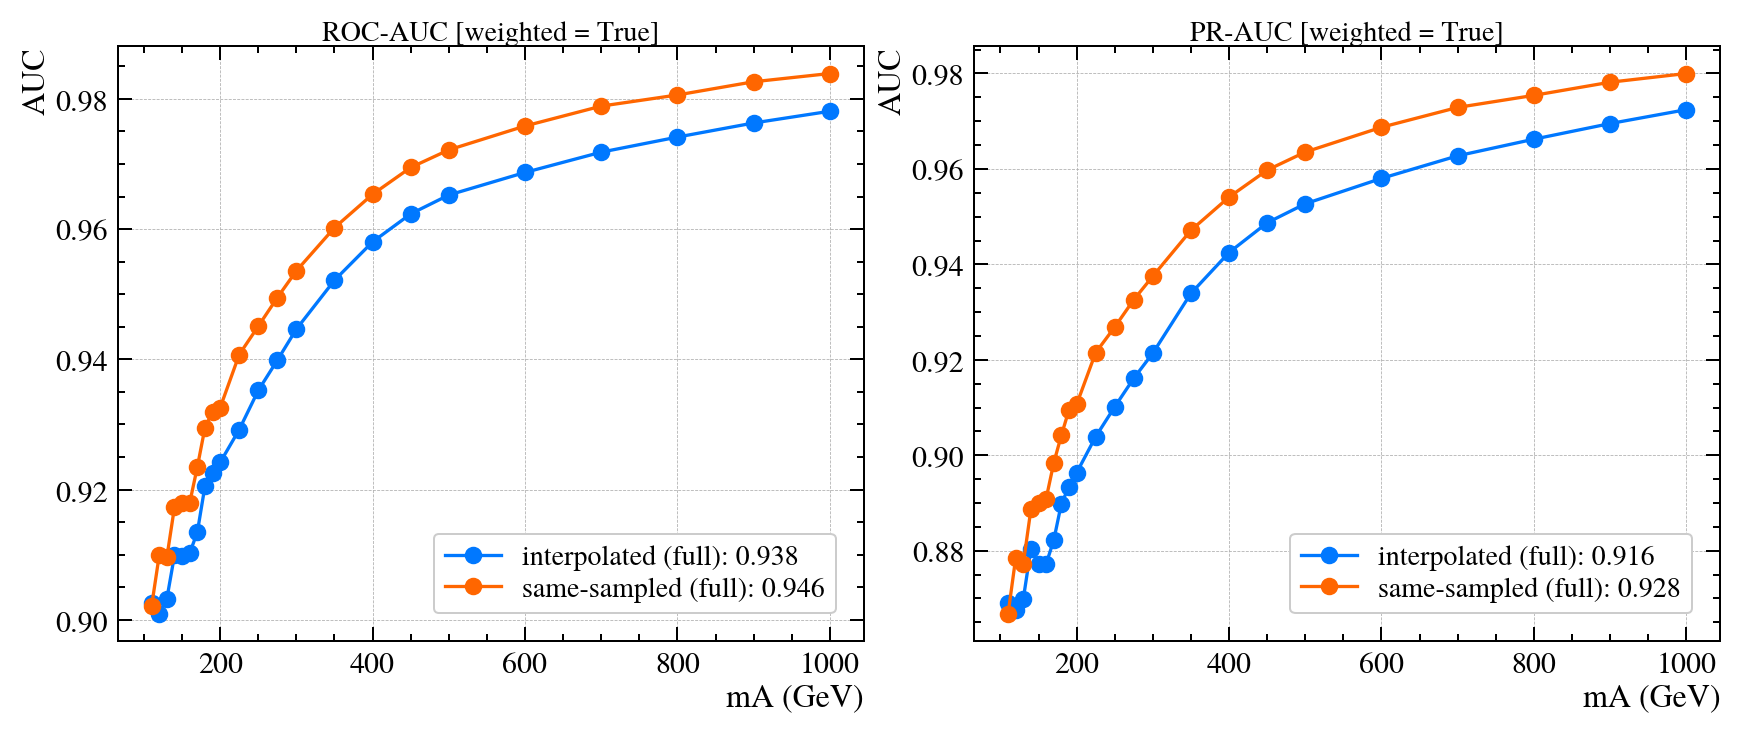

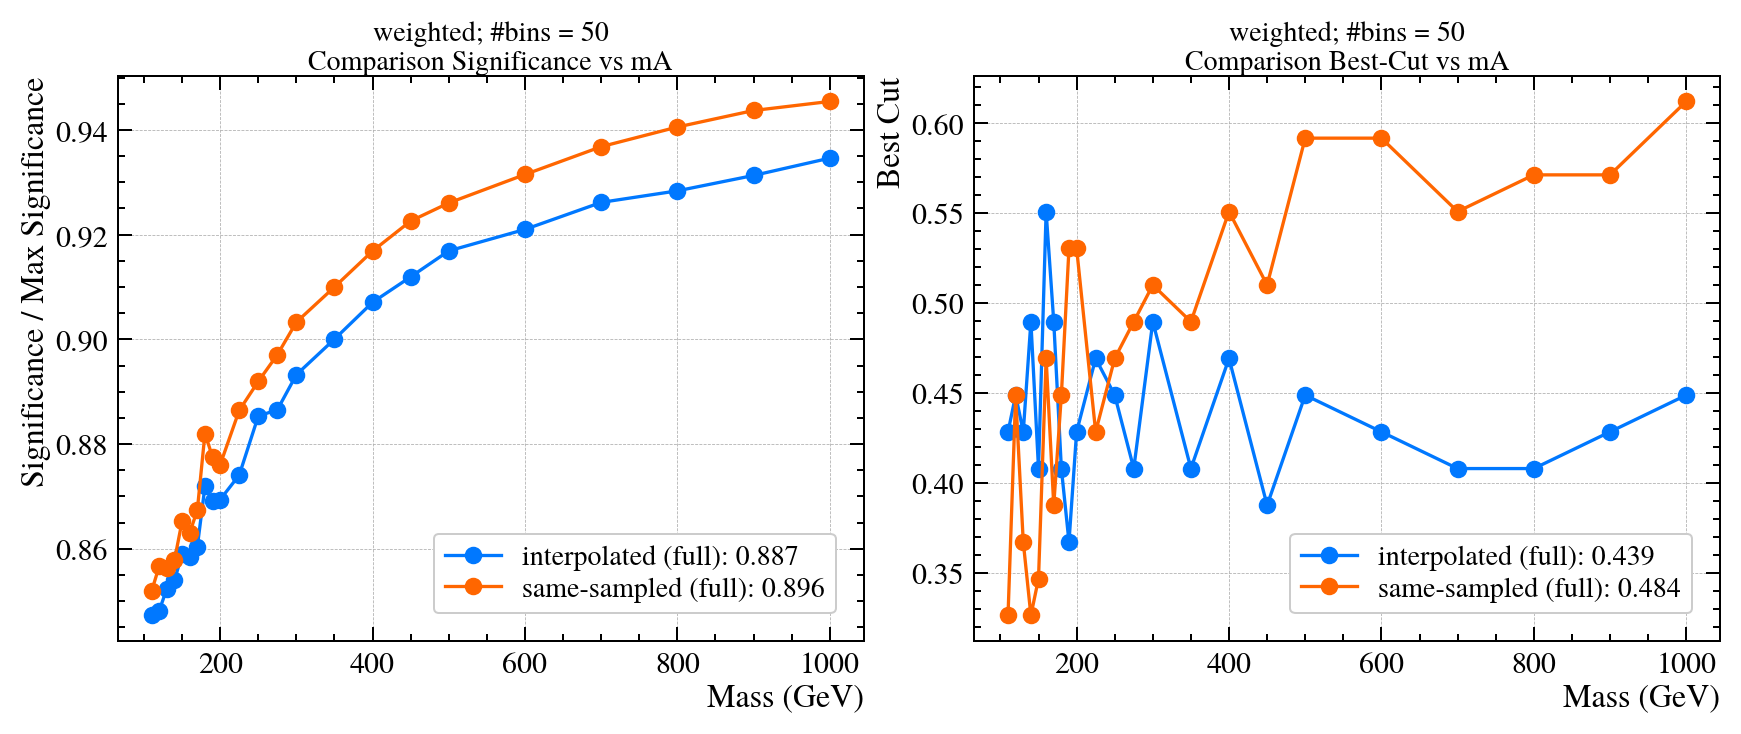

In [38]:
args = dict(dropout=0.25, preprocess=preproc)
base ='same-sampled/pnn-full_balance-preproc'

compare({f'benchmark/interp/{base}': dict(**args, name='interpolated (full)'),
         f'benchmark/{base}': dict(**args, name='same-sampled (full)')},
        test)